In [12]:
gpx_files = [
    'input/activity_16530377085.gpx',
    'input/activity_16547661069.gpx',
    'input/activity_16563648457.gpx',
    'input/activity_16581827767.gpx',
    'input/activity_16587965437.gpx',
    'input/activity_16590736370.gpx'
]

In [13]:
import gpxpy
import pandas as pd

GARMIN_EXTENSION_TAG = '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension'
GARMIN_HR_TAG = '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr'

points = []

for gpx_file in gpx_files:
    with open(gpx_file) as fp:
        gpx = gpxpy.parse(fp)

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                point_ = {
                    'Timestamp': point.time,
                    'Lon'      : point.longitude,
                    'Lat'      : point.latitude,
                    'Elevation': point.elevation
                }

                ext = next((
                    ext for ext in point.extensions
                    if ext.tag == GARMIN_EXTENSION_TAG and ext.find(GARMIN_HR_TAG) != None
                ), None)
                if ext != None:
                    point_['HeartRate'] = float(ext.find(GARMIN_HR_TAG).text)

                points.append(point_)

df = pd.DataFrame.from_records(points).sort_values('Timestamp')

In [14]:
# Placeholder for handling multiple trips
df['TripId'] = 0

In [15]:
# Break the trip into days
# There may be multiple GPX files per day so rely only on trackpoint metadata
# Right now this just looks at the date, would need to be enhanced for overnight rides

# This should be in order of appearance, so already sorted
day_map = {date: idx for idx, date in enumerate(df['Timestamp'].dt.date.unique())}

# Make this 1-based for human readability
df['TripDay'] = df['Timestamp'].dt.date.map(day_map) + 1

In [16]:
# Break trip days further into segments of continous movement based on heuristics
# 1) Each trip day starts a new segment
seg_breaks = (df[['TripId', 'TripDay']] != df[['TripId', 'TripDay']].shift()).any(axis=1)

# Calculate daily today time here for convenience
df['DeltaTime'] = df['Timestamp'].diff().dt.total_seconds()
df.loc[seg_breaks, 'DeltaTime'] = 0
df['TimeDay'] = df.groupby(['TripId', 'TripDay'])['DeltaTime'].cumsum()

# 2) Delay of more then 30 seconds between trackpoints starts a new segment
seg_breaks = seg_breaks | (df['DeltaTime'] > 30)

# This will be later changed to trip day scoped
df['SegmentId'] = seg_breaks.cumsum()

In [17]:
from geopy.distance import distance

df[['PrevLat', 'PrevLon', 'PrevElevation']] = df[['Lat', 'Lon', 'Elevation']].shift(1)
df.loc[1:, 'DeltaDistance'] = df.loc[1:].apply(
    lambda x: (
        distance((x['PrevLat'], x['PrevLon']), (x['Lat'], x['Lon'])).m**2 +
        (x['Elevation'] - x['PrevElevation'])**2
    )**0.5,
    axis=1
)
df.drop(columns=['PrevLat', 'PrevLon', 'PrevElevation'], inplace=True)

In [18]:
# Deltas should be zeroed out at segment breaks
df.loc[seg_breaks, ['DeltaTime', 'DeltaDistance']] = None

df['CurrSpeed'] = 3.6 * df['DeltaDistance'] / df['DeltaTime']
df[['MovingTimeDay', 'DistanceDay']] = df.groupby(['TripId', 'TripDay'])[['DeltaTime', 'DeltaDistance']].cumsum()
df['DistanceDay'] /= 1000

df.drop(columns=['DeltaTime', 'DeltaDistance'], inplace=True)

TripDay
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
5    Axes(0.125,0.11;0.775x0.77)
dtype: object

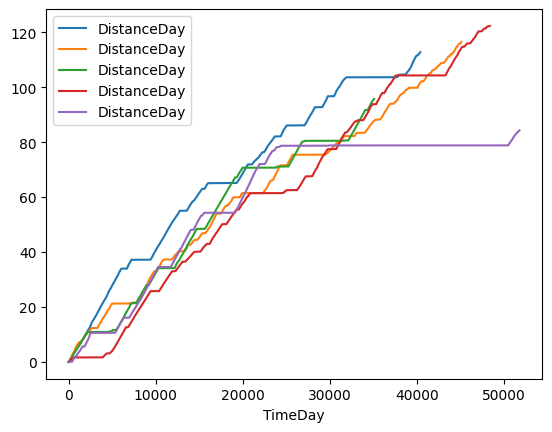

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.dropna().groupby('TripDay').plot.line(x='TimeDay', y='DistanceDay', ax=ax)